<a href="https://colab.research.google.com/github/JustMuk/AI/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

Extracts the dataset into its own folder

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Coursework CV/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Coursework CV/dataset")

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import svm
from natsort import natsorted, ns
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.feature import hog
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import os

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from numpy import unique

**Pre-Processing**

Reads all the training images and stores it into a list

In [246]:
def load_images(image_path):
  path = os.path.join(image_path)
  path = os.listdir(image_path)
  path = natsorted(path)
  image_list = []
  for filename in path:
      # fix
    try:
        image_list.append(io.imread(image_path + "/" + filename,plugin='matplotlib'))
    except:
        print(f'Bad file: {filename}')
  return image_list

Resizes all the images to 64x128 for HOG

In [247]:
def resized_images(image_list):
  resized_imgs = []
  for image in image_list:
    resized_imgs.append(resize(image, (128,64))) # try 64 *64
  return resized_imgs

Calculates the HOG features

In [248]:
def get_hog_features(resized_imgs):
  hog_images = []
  hog_features = []

  for image in resized_imgs:
    blurred_image = cv.GaussianBlur(image,(5,5),0)
    fd, hog_image = hog(blurred_image, orientations = 9, pixels_per_cell =(8,8), cells_per_block = (2,2), visualize = True, multichannel= True)
    hog_images.append(hog_image)
    hog_features.append(fd)
  hog_features = np.array(hog_features)
  hog_features.shape
  return hog_features

Gets the labels from the dataset

In [249]:
def get_labels(label_path):
  labels = []
  with open(label_path, 'r') as f:
    for line in f:
      data = line.split()
      labels.append(data[-1]) 
  label = np.array(labels)
  return label

Hyperparameters

In [250]:
#kernel_type = 'sigmoid'
#C = 0.5
label_path = "/content/drive/MyDrive/Coursework CV/dataset/labels/list_label_train.txt"
image_path ="/content/drive/MyDrive/Coursework CV/dataset/train"
test_path = "/content/drive/MyDrive/Coursework CV/dataset/test"
test_label = "/content/drive/MyDrive/Coursework CV/dataset/labels/list_label_test.txt"

In [251]:
images_list = load_images(image_path)

In [252]:
resized = resized_images(images_list)

In [253]:
hog_featur = get_hog_features(resized)

In [11]:
label = get_labels(label_path)

One hot encoding the labels

(fix for output Dense layer issues of the CNN model)

In [14]:
from tensorflow.keras.utils import to_categorical

one_hot_encode = to_categorical(label)

In [15]:
one_hot_encode.shape

(12271, 8)

(12271, 3780)

In [15]:
reshaped_hog_features = hog_features_array.reshape(12271, 3780,1)

# sanity check
assert reshaped_hog_features[0].shape[1] == 1

Creates the SVM and trains it

In [13]:
svm_classifier = svm.SVC()

X_train, X_test, y_train, y_test = train_test_split(hog_featur, label, test_size = 0.20)

svm_classifier.fit(X_train, y_train)

SVC()

Predicts the labels based on the training

In [15]:
y_pred = svm_classifier.predict(X_test)

Displays the confusion matrix

In [16]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[161   0   0  34  12   0  54]
 [ 13  14   0  19   7   6   7]
 [  6   0  15  23  33   8  48]
 [ 12   0   0 889  20   2  34]
 [  5   0   2  61 218   5 103]
 [  2   0   2  36  19  68  19]
 [ 23   0   2  43  48   0 382]]
              precision    recall  f1-score   support

           1       0.73      0.62      0.67       261
           2       1.00      0.21      0.35        66
           3       0.71      0.11      0.19       133
           4       0.80      0.93      0.86       957
           5       0.61      0.55      0.58       394
           6       0.76      0.47      0.58       146
           7       0.59      0.77      0.67       498

    accuracy                           0.71      2455
   macro avg       0.74      0.52      0.56      2455
weighted avg       0.72      0.71      0.69      2455



Plots Confusion Matrix

['6' '5' '6' ... '7' '4' '4']


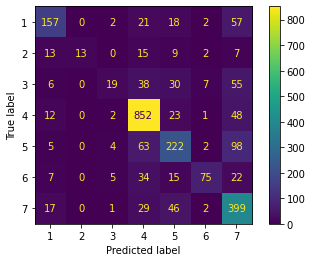

In [31]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

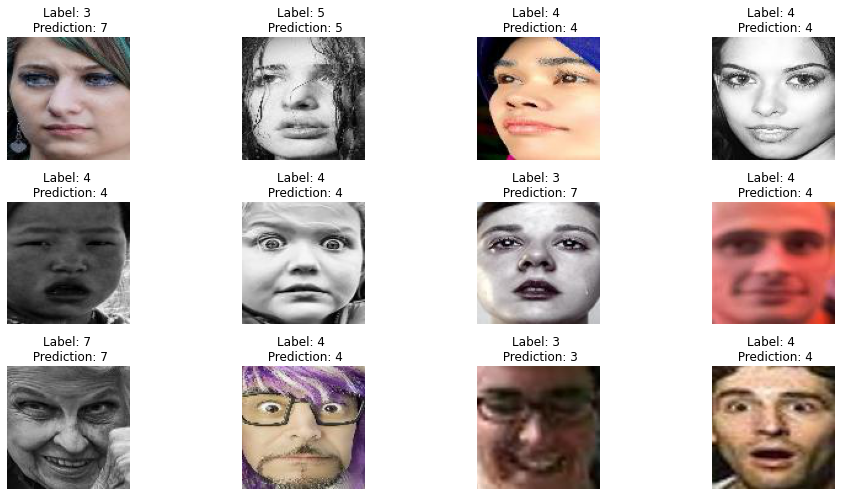

In [20]:
fig, axes = plt.subplots(3, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(12):
    ax[i].imshow(images_list[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

**CNN**

Architecture

In [242]:
from keras.layers import Dropout
import tensorflow
def setup_cnn():
  model = Sequential()
  model.add(Conv1D(64, 2, activation="relu", input_shape=(3780,1)))
  model.add(Conv1D(32, 2, activation="relu"))
  
  model.add(Dense(16, activation="relu"))
  model.add(Dropout(0.2))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(8, activation = 'softmax'))

  hog_features_array = np.array(hog_featur)

  return model

compiling the model

In [243]:
def compile_cnn(model):
  model.compile(loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer = "adam", 
              metrics = ['accuracy'])
  X_train, X_test, y_train, y_test = train_test_split(hog_features_array, one_hot_encode, test_size = 0.20)
  model.summary()
  return model

In [244]:
model = setup_cnn()
model = compile_cnn(model)
results = model.fit(X_train, y_train, validation_data=(X_test,y_test) , batch_size=16,epochs=5)

NameError: ignored

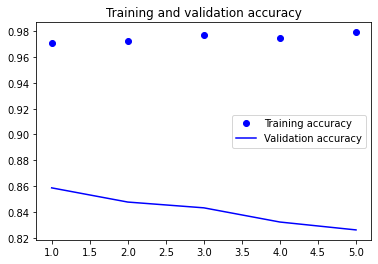

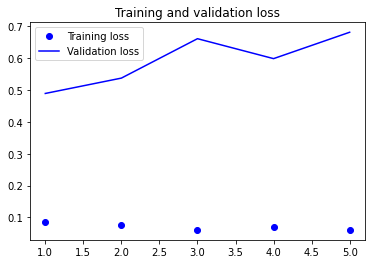

In [59]:
import matplotlib.pyplot as plt

accuracy = results.history["accuracy"]
val_accuracy = results.history["val_accuracy"]
loss = results.history["loss"]
val_loss = results.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [76]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(hog_featur, label, test_size = 0.1)
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [77]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(200,150,100),activation='relu',learning_rate='invscaling', random_state=1)

In [78]:
clf.fit(X_train,y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(200, 150, 100),
              learning_rate='invscaling', random_state=1)

In [79]:
X_test = scaler.transform(X_test)
y_pred = clf.predict(X_test)

In [80]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 91   5   2   5   6   3  17]
 [  9   9   1   7   4   3   0]
 [  3   1  19   9  11   6  15]
 [ 12   2   6 436  13   5  23]
 [  6   2  13  23 103   2  38]
 [  3   2   2   8  12  38   6]
 [ 18   1  12  13  24   5 174]]
              precision    recall  f1-score   support

           1       0.64      0.71      0.67       129
           2       0.41      0.27      0.33        33
           3       0.35      0.30      0.32        64
           4       0.87      0.88      0.87       497
           5       0.60      0.55      0.57       187
           6       0.61      0.54      0.57        71
           7       0.64      0.70      0.67       247

    accuracy                           0.71      1228
   macro avg       0.59      0.56      0.57      1228
weighted avg       0.70      0.71      0.70      1228



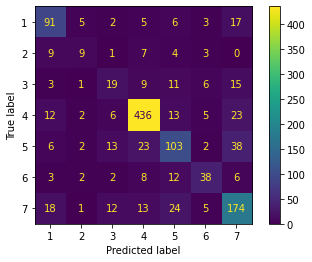

In [82]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [239]:
path_to_testset = test_path
model_type = 'mlp'
#model_type = 'cnn'
#model_type = 'svm'
labels = [1,2,3,4]

In [133]:
import random
import glob
def choose_random_image(path):
  folder = os.listdir(path)
  random_image = random.choice(folder)
  return random_image

In [234]:
import fnmatch
def get_random_image_labels(image, path):
  label = 4
  with open(path, 'r') as f:
    for line in f:
      if fnmatch.fnmatch(image, '*.txt'):
        data = line.split()
        print(data[-1])
          
        #for x in range(len(data)):
         # if data[x].startswith(image):
          #  label = data[x]
            
          
  return data[-1]
          
        
        

In [240]:
images = []
for x in range(4):
    image = choose_random_image(path_to_testset)
    images.append(image)

In [235]:
def EmotionRecognition(path_to_testset, model_type):
  path = path_to_testset
  if model_type == 'cnn':

  
  
  
    #label = get_random_image_labels(image, test_label)
    #print(label)
    #labels.append(label)
    
  label = np.array(labels)
  
  



In [236]:
EmotionRecognition(test_path,"String")

UnboundLocalError: ignored